#### Loading libraries, importing data

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import holidays
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#load in training data
train_df = pd.read_csv(r"D:\Summer Practicum\1_Data\training_airlines.csv")
train_df.shape

C:\Users\bmhawley\AppData\Local\Temp\4\ipykernel_8132\2356045484.py:2: DtypeWarning: Columns (86,93) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(r"D:\Summer Practicum\1_Data\training_airlines.csv")


(3444864, 120)

In [53]:
train_df.groupby("Operating_Airline ")["Flights"].sum()/len(train_df["Flights"])

Operating_Airline 
AA    0.181590
AS    0.047702
B6    0.056814
DL    0.185557
F9    0.032426
G4    0.023476
HA    0.015512
NK    0.049487
UA    0.133742
WN    0.273694
Name: Flights, dtype: float64

#### Trimming and manipulating the trimmed dataframe

In [3]:
#selecting specific columns from the training data
train_df_trim = train_df[["OriginAirportID", "Flights", "FlightDate", "Month", "DayofMonth", "DayOfWeek","Operating_Airline ","Origin", "OriginCityName", "OriginState","Dest","DestCityName",
"DestState","DepTime","DepDelay","DepDel15","DepartureDelayGroups","TaxiOut","TaxiIn","ArrTime","ArrDelay","ArrDel15", "ArrDelayMinutes",
"ArrivalDelayGroups",'Cancelled',"Diverted","ActualElapsedTime","AirTime","Distance","DistanceGroup",
"CarrierDelay","WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay"]]

In [51]:
train_df_trim.groupby("Operating_Airline")["Flights"].sum()/len(train_df_trim["Flights"])

Operating_Airline
AA    0.181590
AS    0.047702
B6    0.056814
DL    0.185557
F9    0.032426
G4    0.023476
HA    0.015512
NK    0.049487
UA    0.133742
WN    0.273694
Name: Flights, dtype: float64

In [4]:
#filling na values in delay fields
train_df_trim[["NASDelay", "SecurityDelay", "CarrierDelay", "WeatherDelay", "LateAircraftDelay"]] = train_df_trim[["NASDelay", \
     "SecurityDelay", "CarrierDelay", "WeatherDelay", "LateAircraftDelay"]].fillna(0)

#creating a total delay field
train_df_trim["TotalDelay"] = train_df_trim[["NASDelay", "SecurityDelay", "CarrierDelay", "WeatherDelay", "LateAircraftDelay"]].sum(axis=1)

#field for if flight was cancelled or diverted
train_df_trim["CancOrDiv"] = train_df_trim["Cancelled"] + train_df_trim["Diverted"]
train_df_trim["CancOrDiv2"] = np.where((train_df_trim["Cancelled"] == 1) | train_df_trim["Diverted"] == 1, 1, 0)
train_df_trim["CancOrDiv2"] == train_df_trim["CancOrDiv"]

#field for if a flight was delayed
train_df_trim["Delayed"] = np.where((train_df_trim["ArrDelayMinutes"]) > 0, 1, 0)

#creating a region column
def state_to_region(state):
    West = ["WA", "MT", "ID", "WY", "OR", "CA", "NV", "UT", "CO", "AZ", "NM", "AK", "HI"]
    South = ["TX", "OK", "AR", "LA", "MS", "AL", "TN", "KY", "FL", "GA", "SC", "NC", "VA", "MD", "DE"]
    Northeast = ["PA", "NJ", "NY", "CT", "MA", "RI", "ME", "NH", "VT"]
    Midwest = ["ND", "SD", "NE", "KS", "MO", "IA", "MN", "WI", "IL", "IN", "OH", "MI"]
    if state in West:
        return "West"
    elif state in South:
        return "South"
    elif state in Northeast:
        return "Northeast"
    elif state in Midwest:
        return "Midwest"
    
train_df_trim["Region"] = train_df_trim["OriginState"].map(state_to_region)

C:\Users\bmhawley\AppData\Local\Temp\4\ipykernel_8132\2662193718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_trim[["NASDelay", "SecurityDelay", "CarrierDelay", "WeatherDelay", "LateAircraftDelay"]] = train_df_trim[["NASDelay", \
C:\Users\bmhawley\AppData\Local\Temp\4\ipykernel_8132\2662193718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_trim["TotalDelay"] = train_df_trim[["NASDelay", "SecurityDelay", "CarrierDelay", "WeatherDelay", "LateAircraftDelay"]].sum(axis=1)
C:\Users\

#### Creating the airports df that has only the top 64 airports (10000 flights +)

In [5]:
airports_df = train_df_trim.groupby("Origin")["Flights"].value_counts().reset_index(name="Yearly_Flights")
airports_df_trim = airports_df[airports_df["Yearly_Flights"] >= 10000]
airports_df_trim = airports_df_trim.sort_values("Yearly_Flights", ascending=False)

airports_df_trim.head(10)


,Origin,Flights,Yearly_Flights
11,ATL,1.0,195905
58,DEN,1.0,152264
59,DFW,1.0,127001
122,LAS,1.0,126041
165,ORD,1.0,111266
123,LAX,1.0,105832
136,MCO,1.0,105561
176,PHX,1.0,98783
210,SEA,1.0,89563
48,CLT,1.0,87669


#### Creating stats by airport

Total want to do:
Percent of flights delayed
Percent of flights diverted or cancelled


Separate sections:

When there is a delay how extreme is the delay (avg delay length given there is a delay)

When there is a delay what percentage of the delay is the fault of the airport (everything other than carrier). arrival delay minutes (early set to 0) total of all non carrier over total arrdelmins

Holiday performance indicator (given it is a holiday, average arrival delay)

In [6]:
#creating column that shows the percent of the delay that is the carriers fault

when_delayed_df = train_df_trim[train_df_trim["TotalDelay"] != 0][["NASDelay", "SecurityDelay", "CarrierDelay", 
                                                                   "WeatherDelay", "LateAircraftDelay", "Origin", "TotalDelay"]]

when_delayed_df = when_delayed_df.reset_index()

when_delayed_df["PercentAirportFault"] = ((when_delayed_df["NASDelay"] + when_delayed_df["SecurityDelay"] + when_delayed_df["WeatherDelay"]) 
                                          / when_delayed_df["TotalDelay"])

#creating a new dataframe that is the average percent that a delay is an airports fault
airport_delay_fault = when_delayed_df.groupby("Origin")["PercentAirportFault"].mean()
airport_delay_fault

Origin
ABE    0.491628
ABQ    0.228651
ACK    0.302557
ACY    0.510539
ADK    0.833801
         ...   
USA    0.272218
VPS    0.308612
WRG    0.274167
XNA    0.283490
YAK    0.207387
Name: PercentAirportFault, Length: 246, dtype: float64

In [7]:
#percent of flights delayed and flights delayed/cancelled
airport_stats_df = train_df_trim.groupby("Origin").agg(
    percent_delayed = ("Delayed", "mean"),
    percent_diverted_cancelled = ("CancOrDiv", "mean")).reset_index() 


In [8]:
#creating the holidays column in the full dataframe
train_df_trim['FlightDate'] = pd.to_datetime(train_df_trim['FlightDate'])
train_df_trim.columns = train_df_trim.columns.str.replace(' ','')

us_holidays = holidays.US(years=range(train_df_trim['FlightDate'].min().year,train_df_trim['FlightDate'].max().year +1))
holiday_dates = {date for date, name in us_holidays.items()}

train_df_trim['Is_Holiday'] = train_df_trim['FlightDate'].dt.date.isin(holiday_dates)
train_df_trim['Is_Delayed'] = (train_df_trim['ArrDelay'] > 0)

C:\Users\bmhawley\AppData\Local\Temp\4\ipykernel_8132\2868795725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_trim['FlightDate'] = pd.to_datetime(train_df_trim['FlightDate'])
C:\Users\bmhawley\AppData\Local\Temp\4\ipykernel_8132\2868795725.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_trim['Is_Holiday'] = train_df_trim['FlightDate'].dt.date.isin(holiday_dates)
C:\Users\bmhawley\AppData\Local\Temp\4\ipykernel_8132\2868795725.py:9: SettingWithCopyWarning: 
A value is trying to b

In [9]:
holiday_df = train_df_trim[train_df_trim["Is_Holiday"] == 1]

holiday_performance_df = holiday_df.groupby("Origin")["Delayed"].mean().reset_index()
holiday_performance_df.head(10)

,Origin,Delayed
0,ABE,0.395833
1,ABQ,0.361364
2,ACK,0.166667
3,ACY,0.211765
4,ADQ,0.300000
5,AKN,0.444444
6,ALB,0.310881
7,AMA,0.301205
8,ANC,0.399123
9,ATL,0.360077


In [10]:
#how extreme is the average delay
only_delayed_flights = train_df_trim[train_df_trim["Delayed"] == 1]
how_extreme_delays = only_delayed_flights.groupby("Origin")["ArrDelayMinutes"].mean().reset_index()

#### Merging the airports information into the top 64 airports dataframe

In [11]:
airports_df_trim

merge1 = pd.merge(airports_df_trim[["Origin", "Yearly_Flights"]], airport_stats_df, how="left", on="Origin")

merge2 = pd.merge(merge1, airport_delay_fault, on="Origin", how="left")

merge3 = pd.merge(merge2, holiday_performance_df, on="Origin", how="left")

merge4 = pd.merge(merge3, how_extreme_delays, on="Origin", how="left")

In [12]:
Final_merge = merge4[["Origin", "Yearly_Flights", "percent_delayed", "percent_diverted_cancelled", "PercentAirportFault"]]
Final_merge["HolidayPercentDelayed"] = merge4["Delayed"]
Final_merge["HowExtremeDelay"] = merge4["ArrDelayMinutes"]

C:\Users\bmhawley\AppData\Local\Temp\4\ipykernel_8132\4256925256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Final_merge["HolidayPercentDelayed"] = merge4["Delayed"]


#### Scoring

In [13]:
#Scoring for all columns with for loop
columns_of_interest = ["percent_delayed", "percent_diverted_cancelled", "PercentAirportFault", "HolidayPercentDelayed", "HowExtremeDelay"]

for column in columns_of_interest:

    quantiles = Final_merge[[column]].quantile([0.25, 0.75])
    twenty_fifth = quantiles.loc[0.25][column]
    seventy_fifth = quantiles.loc[0.75][column]

    Final_merge[("ScoreFrom_" + column)] = 0

    for i in range(len(Final_merge["Origin"])):
        value = Final_merge[column][i]

        if value <= twenty_fifth:
            points = 1
        elif value > twenty_fifth and value <= seventy_fifth:
            points = 0.75
        elif value > seventy_fifth:
            points = 0.5

        Final_merge[("ScoreFrom_" + column)][i] = points

Final_merge["TotalScore"] = Final_merge[["ScoreFrom_percent_delayed", "ScoreFrom_percent_diverted_cancelled","ScoreFrom_PercentAirportFault",
                                         "ScoreFrom_HolidayPercentDelayed", "ScoreFrom_HowExtremeDelay"]].sum(axis=1)



C:\Users\bmhawley\AppData\Local\Temp\4\ipykernel_8132\587992617.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Final_merge[("ScoreFrom_" + column)][i] = points
C:\Users\bmhawley\AppData\Local\Temp\4\ipykernel_8132\587992617.py:22: Sett

In [14]:
Final_merge.sort_values(by="TotalScore", ascending=True)

,Origin,Yearly_Flights,percent_delayed,percent_diverted_cancelled,PercentAirportFault,HolidayPercentDelayed,HowExtremeDelay,ScoreFrom_percent_delayed,ScoreFrom_percent_diverted_cancelled,ScoreFrom_PercentAirportFault,ScoreFrom_HolidayPercentDelayed,ScoreFrom_HowExtremeDelay,TotalScore
6,MCO,105561,0.464054,0.032683,0.331540,0.422373,44.443759,0.50,0.50,0.50,0.75,0.50,2.75
18,FLL,59518,0.432676,0.024514,0.349128,0.447768,46.225419,0.50,0.75,0.50,0.50,0.50,2.75
48,PBI,17340,0.419608,0.032641,0.308447,0.446617,51.867235,0.50,0.50,0.75,0.50,0.50,2.75
16,MIA,61279,0.427797,0.026616,0.331761,0.420459,46.053748,0.50,0.75,0.50,0.75,0.50,3.00
45,SJU,21137,0.415054,0.025973,0.278718,0.455399,49.252707,0.50,0.75,0.75,0.50,0.50,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,MCI,25992,0.341759,0.024815,0.272734,0.313542,37.403130,1.00,0.75,0.75,1.00,0.75,4.25
37,PDX,31508,0.334804,0.024438,0.326341,0.354409,34.523746,1.00,0.75,0.75,0.75,1.00,4.25
59,ABQ,11312,0.360325,0.019979,0.228651,0.361364,40.939647,0.75,1.00,1.00,0.75,0.75,4.25
42,SAT,23765,0.327372,0.021166,0.264613,0.313348,39.538046,1.00,1.00,0.75,1.00,0.75,4.50


#### Merging in the airport latitude and longitude data

In [15]:
#reading in airport locations

airport_locations = pd.read_csv(r"D:\Summer Practicum\0_Personal_Folders\Ben Hawley\QGIS\airport_locations.csv")

merge_locations = pd.merge(Final_merge, airport_locations, how="left", left_on="Origin", right_on="IATA")

merge_locations.to_csv("AirportScores_Locations.csv", index=False)

#### Anova to see differences in arrival delays and scores by region

In [16]:
import statsmodels.formula.api as smf
import statsmodels as sm
from plotnine import *
import matplotlib.pyplot as plt

##### Difference in arrival delays

In [27]:
arrival_delay_model = smf.ols("ArrDelayMinutes ~ C(Region)", data=train_df_trim).fit()

In [ ]:
arrival_delay_region_qq =(ggplot(resids1, aes(sample="residuals")) + geom_qq() + geom_qq_line())
arrival_delay_region_qq.show()

TypeError: Bad type of argument 0            -16.564087
1            -16.564087
2            -19.009917
3            -16.564087
4            -13.635051
                ...    
3444860      196.435913
3444861      -13.635051
3444862      -15.621535
3444863       11.364949
residuals    -16.564087
Length: 3333489, dtype: float64, expected a dataframe or a mapping.

In [45]:
resids1= pd.DataFrame(arrival_delay_model.resid)
resids1.rename(columns={0 : "residuals"}, inplace=True)
resids1

,residuals
0,-16.564087
1,-16.564087
2,-19.009917
3,-16.564087
4,-13.635051
...,...
3444859,-15.621535
3444860,196.435913
3444861,-13.635051
3444862,-15.621535


c:\ProgramData\anaconda3\envs\bens_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 107748 rows containing missing values.


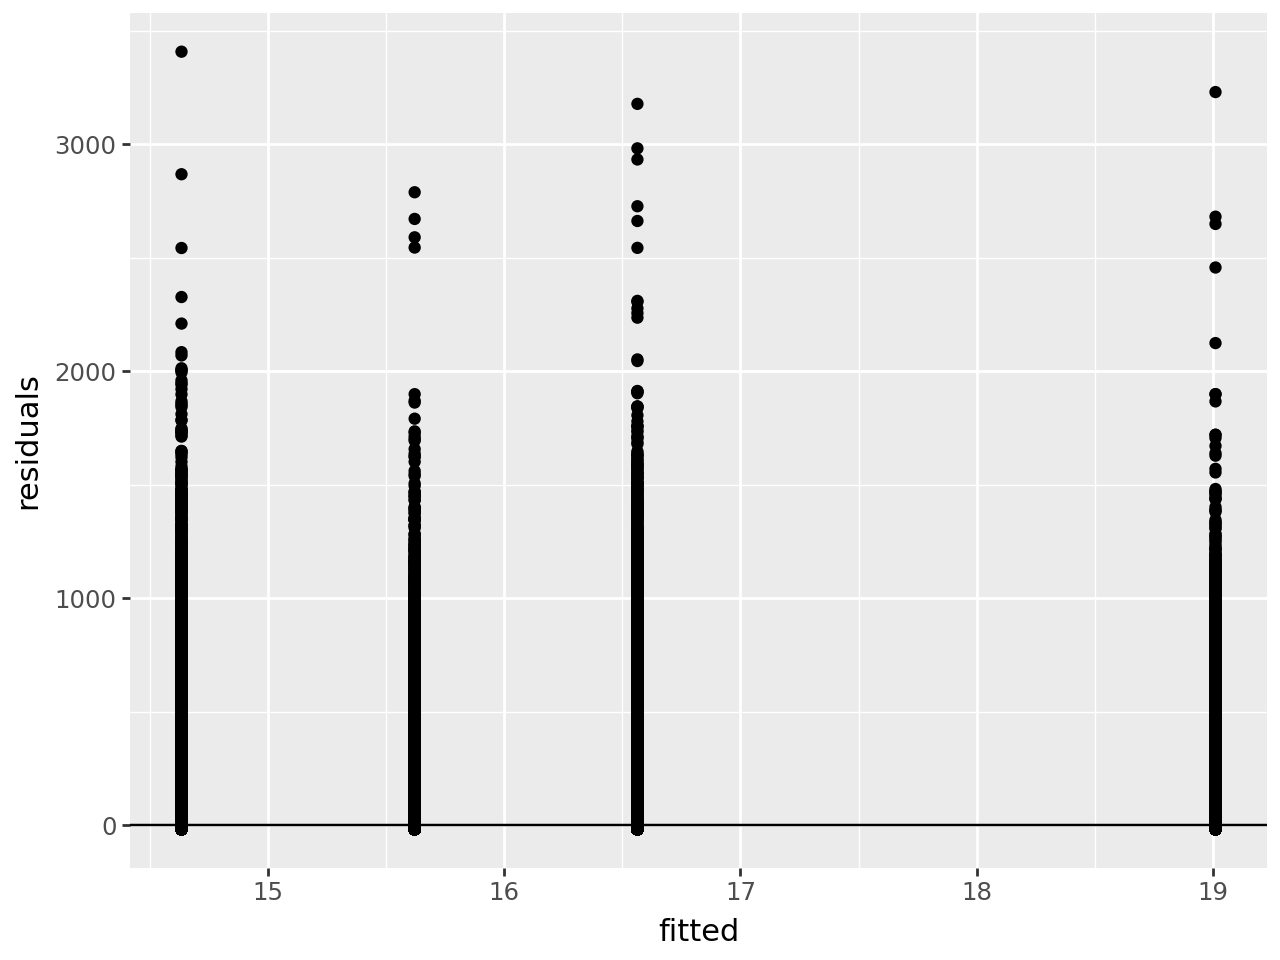

In [ ]:
resids1["fitted"] = arrival_delay_model.fittedvalues
arr_del_region_rvf = ggplot(resids1, aes(x="fitted", y="residuals")) + geom_point() + geom_hline(yintercept=0)
arr_del_region_rvf.show()

In [32]:
sm.api.stats.anova_lm(arrival_delay_model, typ=2)

AttributeError: module 'statsmodels' has no attribute 'api'

##### Difference in scores

#### Alaska airlines